# Image Processing with Noise

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import cv2
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [6]:

destination_folder = '/home/user/Videos/data-20241207T155329Z-001/data'


In [3]:
batch_size = 64

In [19]:
import numpy as np
import cv2

def add_salt_and_pepper_noise(image, salt_prob=0.01, pepper_prob=0.01):

    noisy_image = np.copy(image)
    num_salt = np.ceil(salt_prob * image.size)
    salt_coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape[:2]]
    noisy_image[salt_coords[0], salt_coords[1]] = 255  
    num_pepper = np.ceil(pepper_prob * image.size)
    pepper_coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape[:2]]
    noisy_image[pepper_coords[0], pepper_coords[1]] = 0 
    return noisy_image

def custom_preprocess(image):
    image = np.array(image)
    image = add_salt_and_pepper_noise(image, salt_prob=0.02, pepper_prob=0.02)
    return image


In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    preprocessing_function=custom_preprocess
)

In [8]:

test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=custom_preprocess
)

In [9]:
train_dir = '/home/user/Videos/data-20241207T155329Z-001/data/train'
test_dir = '/home/user/Videos/data-20241207T155329Z-001/data/test'

In [10]:


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 3048 images belonging to 9 classes.
Found 760 images belonging to 9 classes.
Found 1701 images belonging to 9 classes.


In [11]:

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30
)

2024-12-07 22:33:56.113645: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/30
48/48 [==============================] - 66s 1s/step - loss: 1.7725 - accuracy: 0.3852 - val_loss: 1.3969 - val_accuracy: 0.5763
Epoch 2/30
48/48 [==============================] - 63s 1s/step - loss: 1.3254 - accuracy: 0.5650 - val_loss: 1.1850 - val_accuracy: 0.6289
Epoch 3/30
48/48 [==============================] - 62s 1s/step - loss: 1.1732 - accuracy: 0.6260 - val_loss: 1.0829 - val_accuracy: 0.6579
Epoch 4/30
48/48 [==============================] - 63s 1s/step - loss: 1.0749 - accuracy: 0.6516 - val_loss: 0.9766 - val_accuracy: 0.6921
Epoch 5/30
48/48 [==============================] - 77s 2s/step - loss: 1.0038 - accuracy: 0.6755 - val_loss: 0.8880 - val_accuracy: 0.7211
Epoch 6/30
48/48 [==============================] - 81s 2s/step - loss: 0.9351 - accuracy: 0.6988 - val_loss: 0.8572 - val_accuracy: 0.7303
Epoch 7/30
48/48 [==============================] - 80s 2s/step - loss: 0.9131 - accuracy: 0.7080 - val_loss: 0.8454 - val_accuracy: 0.7184
Epoch 8/30
48/48 [==

## Plotting of Accuracy and Loss for training and validation curve

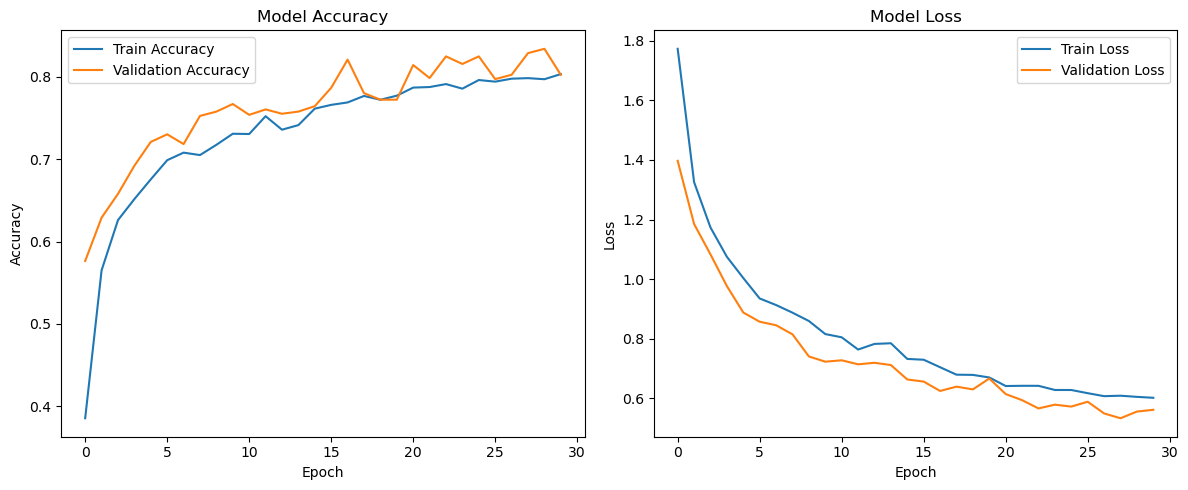

27/27 [==============================] - 20s 721ms/step - loss: 0.6278 - accuracy: 0.7831
Test Accuracy: 78.31%


In [12]:

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.tight_layout()
plt.show()
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

In [14]:
model.save('/home/user/Videos/data-20241207T155329Z-001/data/vehicle_withNOISE_model123.keras')

In [15]:
test_generator.reset()
preds = model.predict(test_generator)
pred_classes = np.argmax(preds, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

27/27 [==============================] - 20s 725ms/step


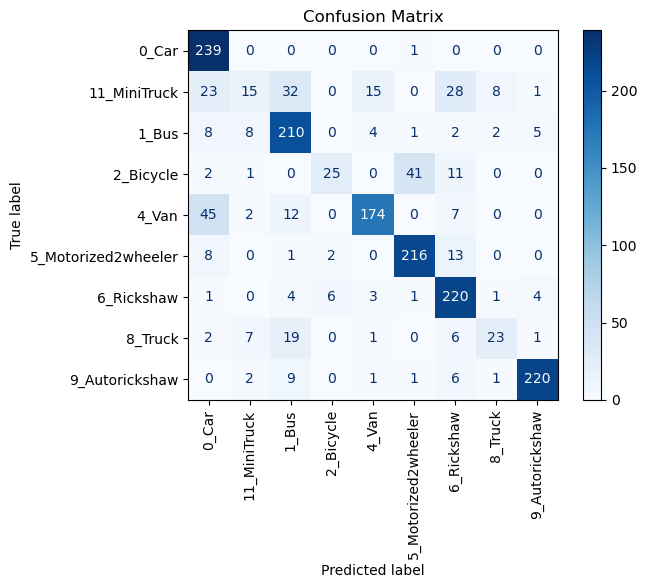

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(true_classes, pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.title("Confusion Matrix")
plt.show()


In [18]:
print("\nClassification Report:")
print(classification_report(true_classes, pred_classes, target_names=class_labels))


Classification Report:
                     precision    recall  f1-score   support

              0_Car       0.73      1.00      0.84       240
       11_MiniTruck       0.43      0.12      0.19       122
              1_Bus       0.73      0.88      0.80       240
          2_Bicycle       0.76      0.31      0.44        80
              4_Van       0.88      0.72      0.79       240
5_Motorized2wheeler       0.83      0.90      0.86       240
         6_Rickshaw       0.75      0.92      0.83       240
            8_Truck       0.66      0.39      0.49        59
     9_Autorickshaw       0.95      0.92      0.93       240

           accuracy                           0.79      1701
          macro avg       0.75      0.68      0.69      1701
       weighted avg       0.78      0.79      0.76      1701



# prediction

In [2]:
from tensorflow.keras.models import load_model
model_path = '/home/user/Videos/data-20241207T155329Z-001/data/vehicle_withNOISE_model123.keras'
model = load_model(model_path)


2024-12-07 23:35:53.116802: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-07 23:35:53.212020: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-07 23:35:54.232137: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-07 23:35:55.788302: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at htt

In [ ]:
import numpy as np
import cv2

def preprocess_image(image_path, target_size=(224, 224)):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image at {image_path} could not be loaded.")
    
    image = cv2.resize(image, target_size)
    image = image / 255.0
    image = np.expand_dims(image, axis=0)
    return image
image_path = '/home/user/Downloads/d167f6b0848e62834ff57140235c1ab6.webp'
preprocessed_image = preprocess_image(image_path)

predictions = model.predict(preprocessed_image)
predicted_class = np.argmax(predictions)
class_mapping = {
    0: "Car",
    1: "Mini Truck",
    2: "Bus",
    3: "Bicycle",
    4: "Van",
    5: "Bike",
    6: "Rickshaw",
    7: "SUV",
    8: "Truck",
    9: "Auto Rickshaw"
}
vehicle_type = class_mapping.get(predicted_class, "Unknown")
print(f"Predicted Class Index: {predicted_class}")
print(f"Predicted Vehicle Type: {vehicle_type}")
print(f"Class Probabilities: {predictions}")
